imports

In [61]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy.stats.mstats import winsorize


Note: you may need to restart the kernel to use updated packages.


read csv files

In [62]:
aisles=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\aisles.csv")
departments=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\departments.csv")
order_products_prior=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\order_products__prior.csv")
order_products_train=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\order_products__train.csv")
orders=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\orders.csv")
products=pd.read_csv("C:\\Users\\kareem khouri\\Desktop\\project\\datasets\\products.csv")

save memory

In [63]:
def reduce_memory(df):
  for column in df.columns:
    if df[column].dtype != object:
      if df[column].dtype == 'int64':
        df[column]=df[column].astype('int32')
      if df[column].dtype == 'float64':
        df[column]=df[column].astype('float32')
  return df
aisles=reduce_memory(aisles) 
departments=reduce_memory(departments) 
order_products_prior=reduce_memory(order_products_prior) 
order_products_train=reduce_memory(order_products_train) 
orders=reduce_memory(orders) 
products=reduce_memory(products)

join files 

In [64]:
all_products=products.merge(aisles,on='aisle_id',how='left')
all_products=all_products.merge(departments,on='department_id',how='left')
df=pd.merge(order_products_prior, all_products, on='product_id', how='left')
df_prior=pd.merge(df, orders, on='order_id', how='left')

In [65]:
df_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [66]:
all_products=products.merge(aisles,on='aisle_id',how='left')
all_products=all_products.merge(departments,on='department_id',how='left')
df=pd.merge(order_products_train, all_products, on='product_id', how='left')
df_train=pd.merge(df, orders, on='order_id', how='left')

In [67]:
df_train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0


EDA

1-missing value visualization

In [68]:
missing_values=df_prior.isnull().sum()
print(missing_values)

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64


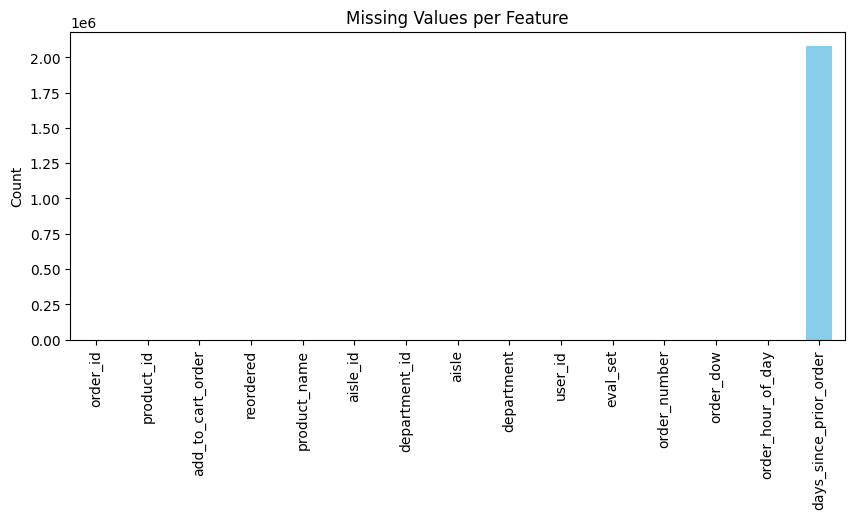

In [69]:
missing_values=df_prior.isnull().sum()
plt.figure(figsize=(10, 4))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Missing Values per Feature')
plt.ylabel('Count')
plt.show()

2-Distribution plots for numeric features and target(s) (histogram, density)

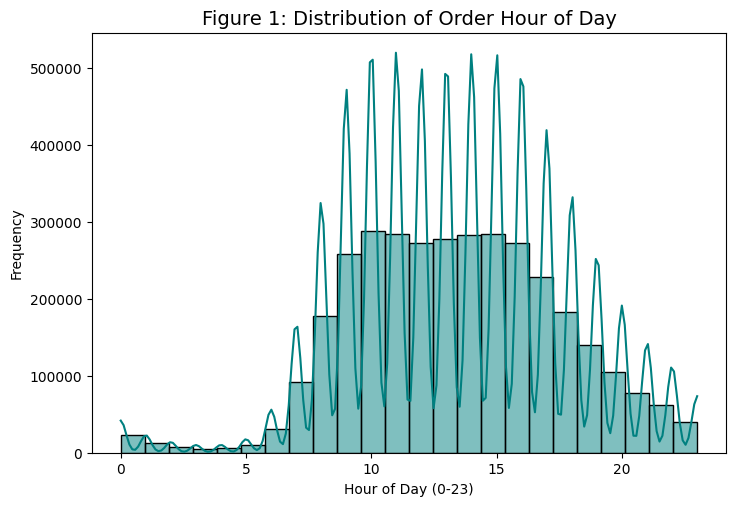

In [70]:
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 1)
sns.histplot(orders['order_hour_of_day'], kde=True, color='teal', bins=24)
plt.title('Figure 1: Distribution of Order Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Frequency')
plt.show()

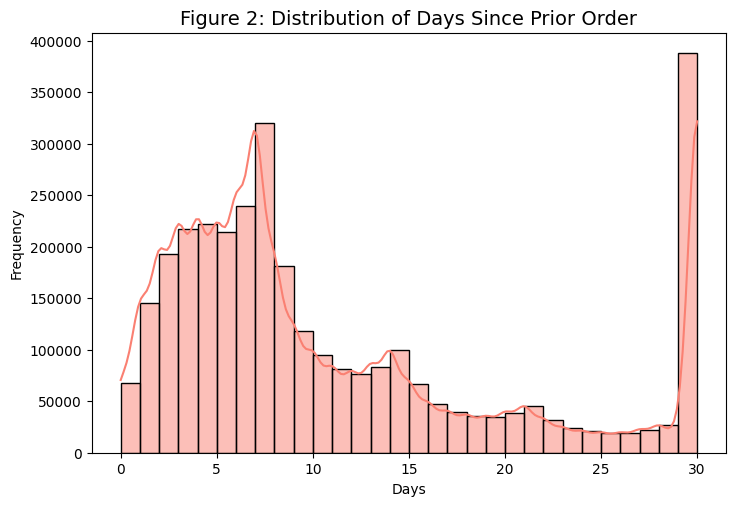

In [71]:
plt.figure(figsize=(18,12))
plt.subplot(2, 2, 2)
sns.histplot(orders['days_since_prior_order'], kde=True, color='salmon', bins=30)
plt.title('Figure 2: Distribution of Days Since Prior Order', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

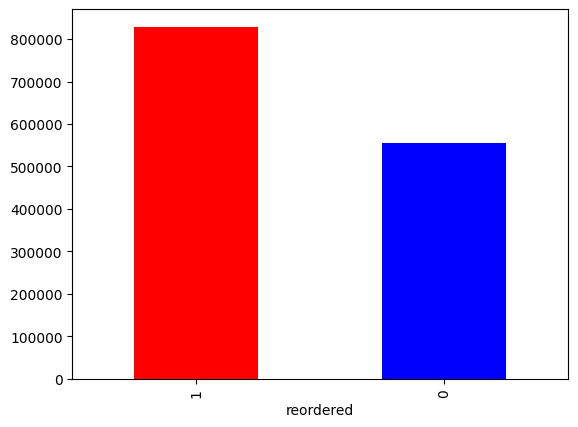

In [72]:
df['reordered'].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.show()

Categorical cardinality analysis

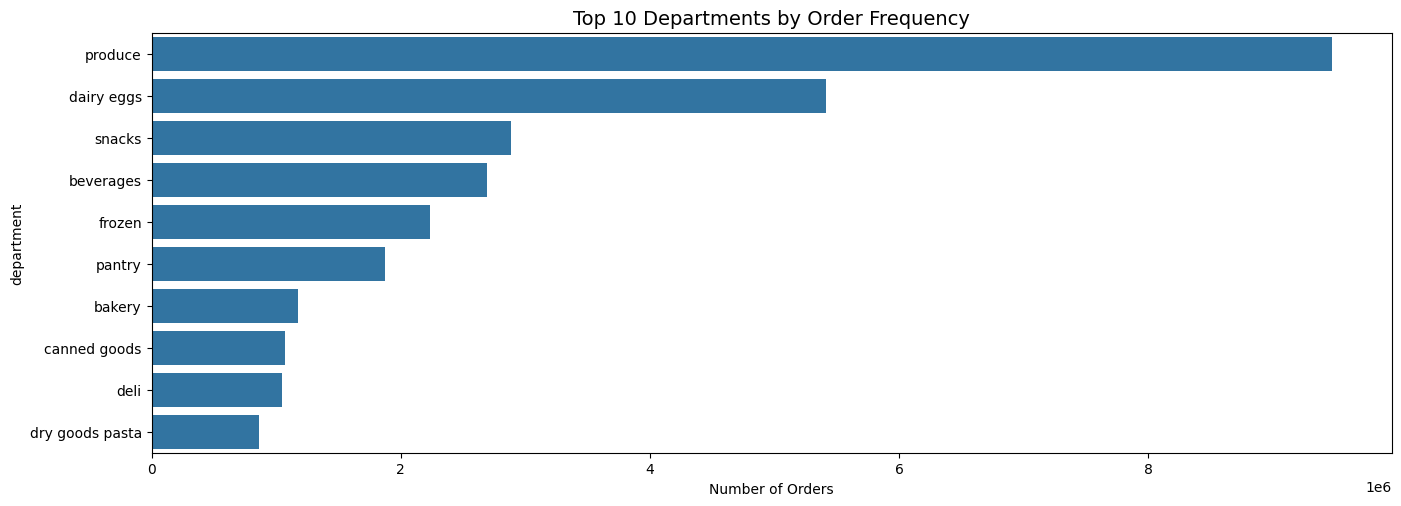

In [73]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
top_departments_counts = df_prior['department'].value_counts().head(10)
sns.barplot(x=top_departments_counts.values, y=top_departments_counts.index)
plt.title('Top 10 Departments by Order Frequency', fontsize=14)
plt.xlabel('Number of Orders')
plt.show()

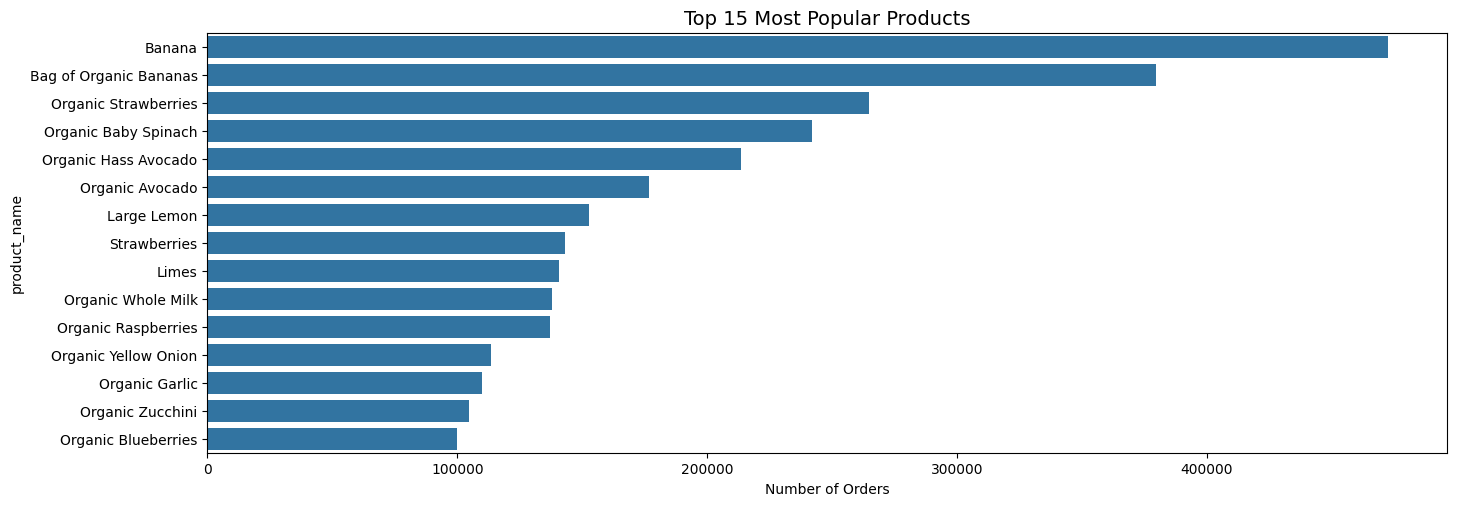

In [74]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 2)
top_products_counts = df_prior['product_name'].value_counts().head(15)
sns.barplot(x=top_products_counts.values, y=top_products_counts.index)
plt.title('Top 15 Most Popular Products', fontsize=14)
plt.xlabel('Number of Orders')
plt.show()

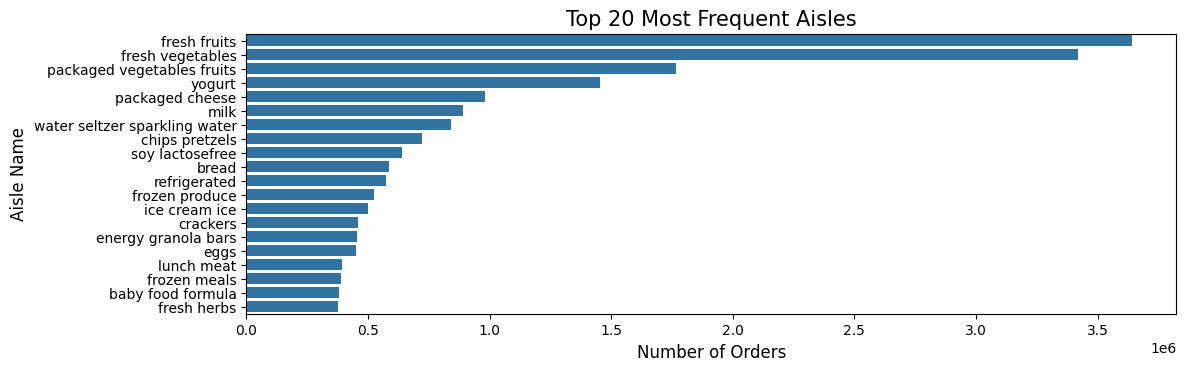

In [75]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 2)
top_aisle_counts = df_prior['aisle'].value_counts().head(20)
sns.barplot(x=top_aisle_counts.values, y=top_aisle_counts.index)
plt.title('Top 20 Most Frequent Aisles', fontsize=15)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Aisle Name', fontsize=12)
plt.show()

Correlation matrix, heatmap and pairwise scatter plots for selected numeric features

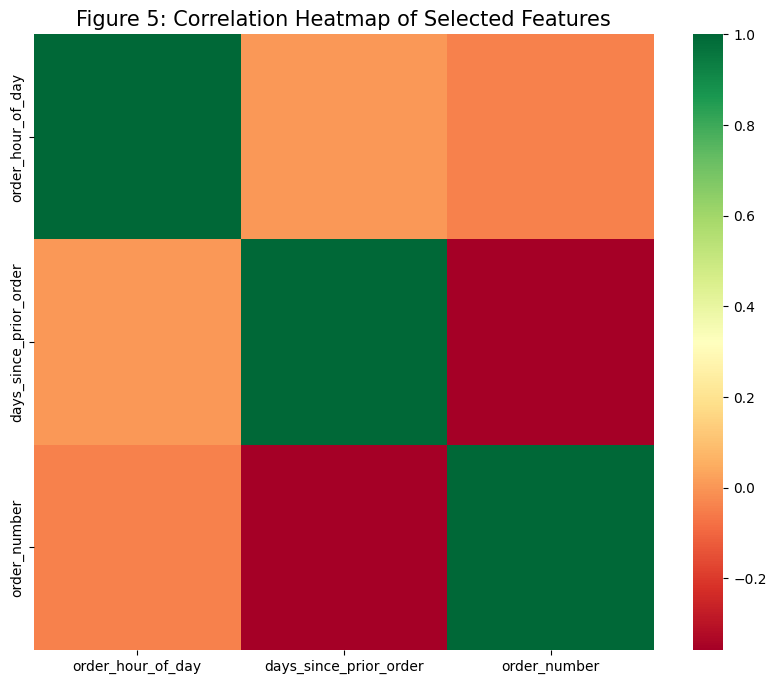

In [76]:
numeric_columns=['order_hour_of_day','days_since_prior_order','order_number']
corr_matrix=df_prior[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,cmap='RdYlGn')
plt.title('Figure 5: Correlation Heatmap of Selected Features', fontsize=15)
plt.show()


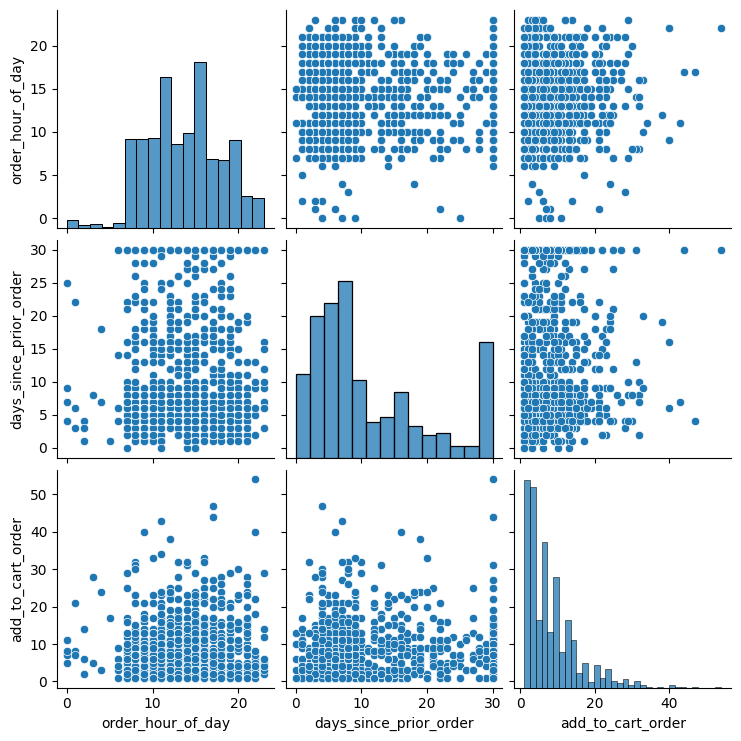

In [77]:
cols = ['order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order']
df_sample = df_prior[cols].sample(1000)
sns.pairplot(df_sample)
plt.show()

Cleaning & Imputation

In [78]:
df_prior['days_since_prior_order_sentinel'] = df_prior['days_since_prior_order'].fillna(-1)
median_value = df_prior['days_since_prior_order'].median()
df_prior['days_since_prior_order'] = df_prior['days_since_prior_order'].fillna(median_value)
print("for insurance:")
print(df_prior['days_since_prior_order'].isna().sum())
print((df_prior['days_since_prior_order_sentinel'] == -1).sum())
print()
print(median_value)
df_prior['days_since_prior_order'].describe()

for insurance:
0
2078068

8.0


count    3.243449e+07
mean     1.090520e+01
std      8.526975e+00
min      0.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

In [79]:
Q1 = df_prior['days_since_prior_order'].quantile(0.25)
Q3 = df_prior['days_since_prior_order'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df_prior[(df_prior['days_since_prior_order'] < lower) | (df_prior['days_since_prior_order'] > upper)]
print("Nmber of outliers: ",len(outliers))

Nmber of outliers:  3499046


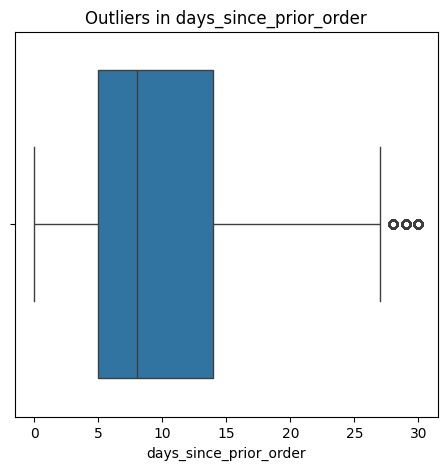

In [80]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(x=df_prior['days_since_prior_order'])
plt.title("Outliers in days_since_prior_order")
plt.show()

In [81]:
df_prior['days_since_prior_order_winsorized'] = winsorize(df_prior['days_since_prior_order'], limits=[0.05, 0.05] )  # winsorization=0.05

In [82]:
upper_limit = df_prior['days_since_prior_order'].quantile(0.95)
(df_prior['days_since_prior_order_winsorized'] > upper_limit).sum()

np.int64(0)